In [ ]:
# Importing modules
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from keras.optimizers import AdamW

Importing and splitting the dataset

In [ ]:
(train_set, valid_set, test_set), (data_info)  = tfds.load(
    name="citrus_leaves",
    split=["train[:70%]", "train[70:85%]", "train[85%:]"],
    as_supervised=True,
    shuffle_files = True,
    with_info = True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/594 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/citrus_leaves/0.1.2.incompleteQH9GZ7/citrus_leaves-train.tfrecord*...:   0…

Dataset citrus_leaves downloaded and prepared to /root/tensorflow_datasets/citrus_leaves/0.1.2. Subsequent calls will reuse this data.


In [ ]:
train_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
valid_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Getting the sizes of train, validation, and test datasets.

In [ ]:
print(train_set.cardinality().numpy())

416


In [ ]:
print(valid_set.cardinality().numpy())

89


In [ ]:
print(test_set.cardinality().numpy())

89


We see that 594 images are available and that there are 4 labels.

In [ ]:
data_info

tfds.core.DatasetInfo(
    name='citrus_leaves',
    full_name='citrus_leaves/0.1.2',
    description="""
    The original citrus dataset contains 759 images of healthy and unhealthy citrus
    fruits and leaves. However, for now we only export 594 images of citrus leaves
    with the following labels: Black Spot, Canker, Greening, and Healthy. The
    exported images are in PNG format and have 256x256 pixels.
    
    NOTE: Leaf images with Melanose label were dropped due to very small count and
    other non-leaf images being present in the same directory.
    
    Dataset URL: https://data.mendeley.com/datasets/3f83gxmv57/2
    License: http://creativecommons.org/licenses/by/4.0
    """,
    homepage='https://data.mendeley.com/datasets/3f83gxmv57/2',
    data_dir=PosixGPath('/tmp/tmpmi_apbdqtfds'),
    file_format=tfrecord,
    download_size=63.87 MiB,
    dataset_size=37.89 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/f

Visualizing examples.

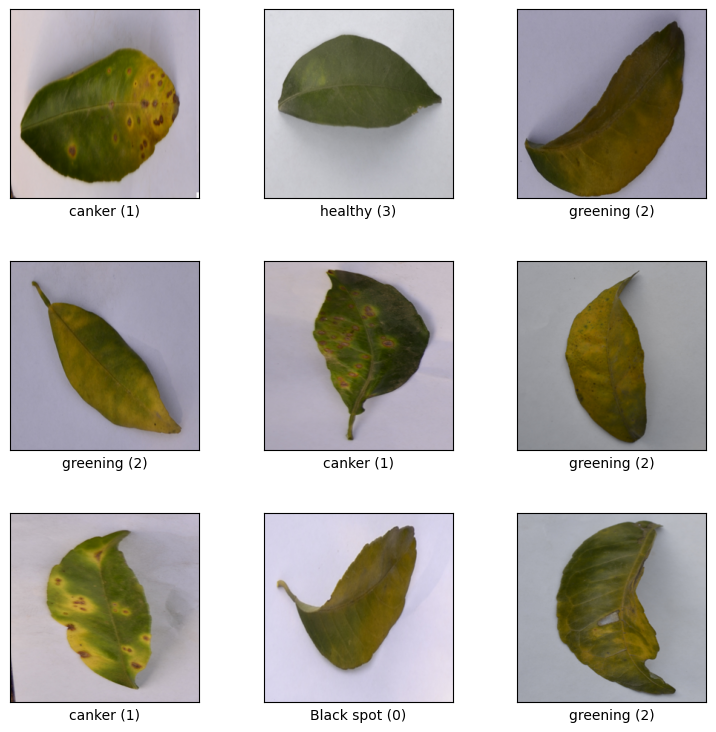

In [ ]:
fig = tfds.show_examples(train_set, tfds.builder('citrus_leaves').info)

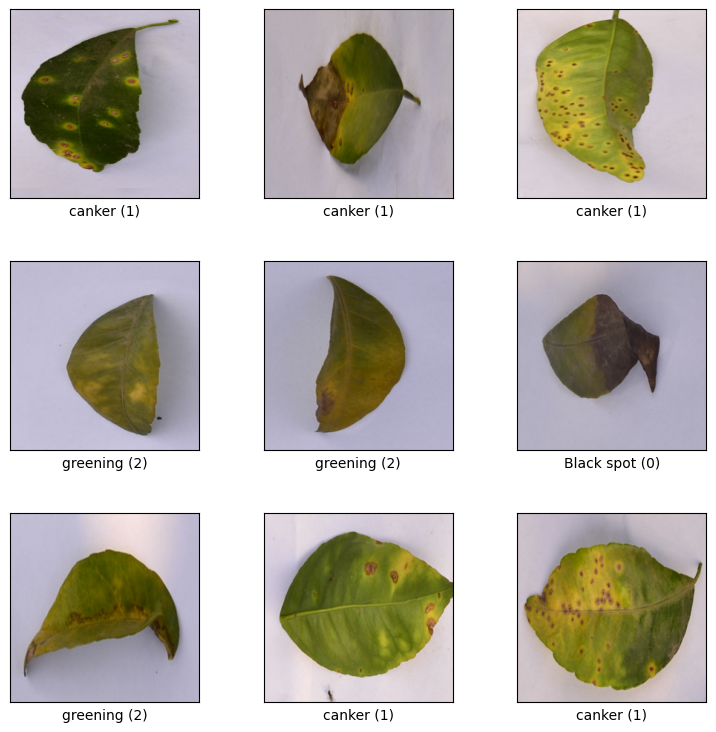

In [ ]:
fig2 = tfds.show_examples(valid_set, tfds.builder('citrus_leaves').info)

Defining a function, which will normalize our images and resize them.

In [ ]:
image_size = (200, 200)
def normalize(image, label):
    normalized_image = tf.image.resize(image, image_size)
    normalized_image /= 255
#    normalized_image = tf.cast(normalized_image, tf.float16)
    return normalized_image, label

Normalizing our images and dividing them into batches of size 32, we will also shuffle the training set.

In [ ]:
train_set = train_set.shuffle(7_000, seed=42).map(normalize).batch(32, drop_remainder=True).prefetch(1)
valid_set = valid_set.map(normalize).batch(32, drop_remainder=True).cache().prefetch(1)
test_set = test_set.map(normalize).batch(32, drop_remainder=True).cache().prefetch(1)
tf.random.set_seed(42)

Building our CNN model.

In [ ]:
tf.random.set_seed(42)
model = Sequential()
model.add(Conv2D(input_shape=(200, 200, 3), filters=32,activation='relu',
                 kernel_size=(3,3),padding='same'
                 ))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,activation='relu',
                 kernel_size=(3,3),padding='same'
                 ))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128,activation='relu',
                 kernel_size=(3,3),padding='same'
                 ))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=256,activation='relu',
                 kernel_size=(3,3),padding='same'
                 ))
model.add(tf.keras.layers.GlobalAvgPool2D())
# model.add(Flatten())
model.add(tf.keras.layers.Dropout(0.25)),
# model.add(Dense(256, activation='relu')),
# model.add(tf.keras.layers.Dropout(0.8)),
# model.add(Dense(128, activation='relu')),
# model.add(tf.keras.layers.Dropout(0.5)),
model.add(Dense(4, activation='softmax'))

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints",
                                                   save_weights_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience=25,
                                                     restore_best_weights=True)

In [ ]:
train_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(32, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32,), dtype=tf.int64, name=None))>

Compiling the model.

In [ ]:
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 100, 100, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 50, 50, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 25, 25, 128)      

Training and evaluating our model.

In [ ]:
history = model.fit(train_set, epochs=250,
                    validation_data=(valid_set), callbacks=[checkpoint_cb, early_stopping_cb])
score = model.evaluate(test_set)

Epoch 1/250
13/13 [==============================] - 2s 66ms/step - loss: 1.3637 - accuracy: 0.2957 - val_loss: 1.3354 - val_accuracy: 0.2656
Epoch 2/250
13/13 [==============================] - 1s 47ms/step - loss: 1.3286 - accuracy: 0.2812 - val_loss: 1.2505 - val_accuracy: 0.2656
Epoch 3/250
13/13 [==============================] - 1s 48ms/step - loss: 1.2588 - accuracy: 0.3462 - val_loss: 1.1226 - val_accuracy: 0.3594
Epoch 4/250
13/13 [==============================] - 1s 48ms/step - loss: 1.1540 - accuracy: 0.4159 - val_loss: 0.9989 - val_accuracy: 0.5938
Epoch 5/250
13/13 [==============================] - 1s 48ms/step - loss: 1.0810 - accuracy: 0.4663 - val_loss: 0.8926 - val_accuracy: 0.5781
Epoch 6/250
13/13 [==============================] - 1s 53ms/step - loss: 1.0377 - accuracy: 0.4495 - val_loss: 0.9475 - val_accuracy: 0.4375
Epoch 7/250
13/13 [==============================] - 1s 60ms/step - loss: 1.0418 - accuracy: 0.4423 - val_loss: 0.8838 - val_accuracy: 0.5781
Epoch 

As you can see, the accuracy on the test set is 0.9531

In [ ]:
# score = model.evaluate(test_set)

Visualizing the training process.

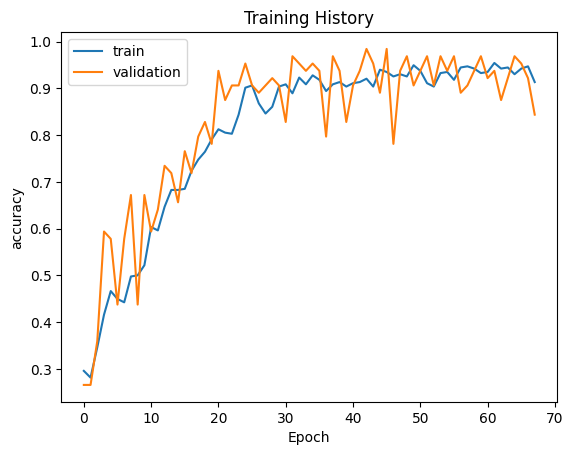

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.title('Training History'),
plt.xlabel('Epoch'),
plt.ylabel('accuracy')
plt.show()

Saving the model

In [ ]:
model.save('citrus_model.keras')

In [ ]:
# new_model = tf.keras.models.load_model('citrus_model.keras')